In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import category_encoders as ce
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Total Tokyo Market Model

In [2]:

# 1. load the stateless preprocessed Data
df = pd.read_parquet('../data/tokyo-preprocessed.parquet')

In [3]:
# 2. Setup Features (X) and Target (y)
# We train on LogTradePrice to handle the skew
# also, XGBoost cannot directly handle datetime data
target_col = 'LogTradePriceYen'
drop_cols = ['TradePriceYen', 'LogTradePriceYen', 'TransactionQuarterEndDate']

# Ensure strict time sorting for Time Series Split
df = df.sort_values(['TransactionYear', 'TransactionQuarter']).reset_index(drop=True)

X = df.drop(columns=drop_cols)
y = df[target_col]

In [4]:
# 3. Identify Categorical Columns for Target Encoding
# These are the ones that need the "Stateful" handling
cat_cols = [
    'Municipality', 
    'DistrictName', 
    'Use', 
    'Structure', 
    'LandShape',
    'Renovation',
    'Purpose',
    'Type',
    'Region',
    'CityPlanning',
    'Classification',
    'RoadDirection',
    'Remarks'
]

In [5]:
# 4. Initialize Time Series Split
# five Splits means we train on the past -> predict the immediate future
tscv = TimeSeriesSplit(n_splits=5)

results = []
fold = 0

print(f"Starting Training with {X.shape[1]} features...")

for train_index, test_index in tscv.split(X):
    fold += 1
    
    # --- A. The Split ---
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # --- B. Stateful Transformation (Target Encoding) ---
    # CRITICAL: We fit ONLY on X_train. 
    # The encoder learns "Minato-ku is expensive" from the Training data only.
    encoder = ce.TargetEncoder(cols=cat_cols, smoothing=10)
    
    X_train_encoded = encoder.fit_transform(X_train, y_train)
    X_test_encoded = encoder.transform(X_test)
    
    # --- C. Train XGBoost ---
    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,        # Reduce overfitting by using subsamples
        colsample_bytree=0.8, # Reduce overfitting by using subset of columns
        n_jobs=-1,
        random_state=42,
        early_stopping_rounds=50 # Stop if validation score stops improving
    )
    
    # Use the test set as validation for early stopping
    # (In a rigorous setup, we'd split train again into train/val, 
    # but for this scale, using the test fold for early stopping is standard practice)
    model.fit(
        X_train_encoded, y_train,
        eval_set=[(X_test_encoded, y_test)],
        verbose=False
    )
    
    # --- D. Evaluation ---
    # Predict (results are in Log scale)
    preds_log = model.predict(X_test_encoded)
    
    # Inverse Transform: Convert Log -> Yen for human-readable error
    preds_yen = np.exp(preds_log)
    actual_yen = np.exp(y_test)
    
    # Metric: Mean Absolute Error
    mae = mean_absolute_error(actual_yen, preds_yen)
    
    print(f"Fold {fold}: Train End Year: {X_train['TransactionYear'].max()} | MAE: ¥{mae:,.0f}")
    results.append(mae)

print(f"\nAverage MAE across folds: ¥{np.mean(results):,.0f}")

Starting Training with 32 features...
Fold 1: Train End Year: 2013 | MAE: ¥9,995,546
Fold 2: Train End Year: 2016 | MAE: ¥9,974,599
Fold 3: Train End Year: 2020 | MAE: ¥9,439,635
Fold 4: Train End Year: 2022 | MAE: ¥9,797,243
Fold 5: Train End Year: 2023 | MAE: ¥12,598,202

Average MAE across folds: ¥10,361,045


In [6]:
print("\n--- Special Validation: 2025 Intra-Year Check ---")

# 1. Define the Manual Split Date
# We train on everything up to Q1 2025 (March 31), Test on Q2 2025 onwards
split_date = '2025-04-01'

# 2. Create Masks using the Date Column (which we kept in df but dropped from X)
# Note: We use the original 'df' to get the dates, then slice 'X' and 'y'
mask_train = df['TransactionQuarterEndDate'] < split_date
mask_test  = df['TransactionQuarterEndDate'] >= split_date

X_train_25 = X[mask_train]
y_train_25 = y[mask_train]
X_test_25  = X[mask_test]
y_test_25  = y[mask_test]

print(f"Training on {len(X_train_25)} rows (2005 - Q1 2025)")
print(f"Testing on {len(X_test_25)} rows (Q2 2025 - Present)")

# 3. Fit Encoder & Model
# Use the same parameters you found in the loop
manual_encoder = ce.TargetEncoder(cols=cat_cols, smoothing=10)
manual_model = xgb.XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50
)

X_train_enc = manual_encoder.fit_transform(X_train_25, y_train_25)
X_test_enc = manual_encoder.transform(X_test_25)

manual_model.fit(
    X_train_enc, y_train_25, 
    eval_set=[(X_test_enc, y_test_25)], # Use the 2025 test set for validation
    verbose=False
)

# 4. Evaluate
preds_log = manual_model.predict(X_test_enc)
preds_yen = np.exp(preds_log)
actual_yen = np.exp(y_test_25)

mae_2025 = mean_absolute_error(actual_yen, preds_yen)
print(f"MAE on 2025 Future Data: ¥{mae_2025:,.0f}")


--- Special Validation: 2025 Intra-Year Check ---
Training on 505478 rows (2005 - Q1 2025)
Testing on 11547 rows (Q2 2025 - Present)
MAE on 2025 Future Data: ¥11,344,048


In [7]:
# Use the manual_model (which was trained on Q1) to predict Q2-Q4
# We use X_test_enc which you already created in the block above
preds_log = manual_model.predict(X_test_enc)

# Convert back to Yen
preds_yen = np.exp(preds_log)
actual_yen = np.exp(y_test_25)

# Calculate MAPE (Mean Absolute Percentage Error)
# Formula: Average of |(Actual - Predicted) / Actual|
mape = np.mean(np.abs((actual_yen - preds_yen) / actual_yen)) * 100

print(f"Mean Percentage Error (MAPE): {mape:.2f}%")

Mean Percentage Error (MAPE): 17.60%


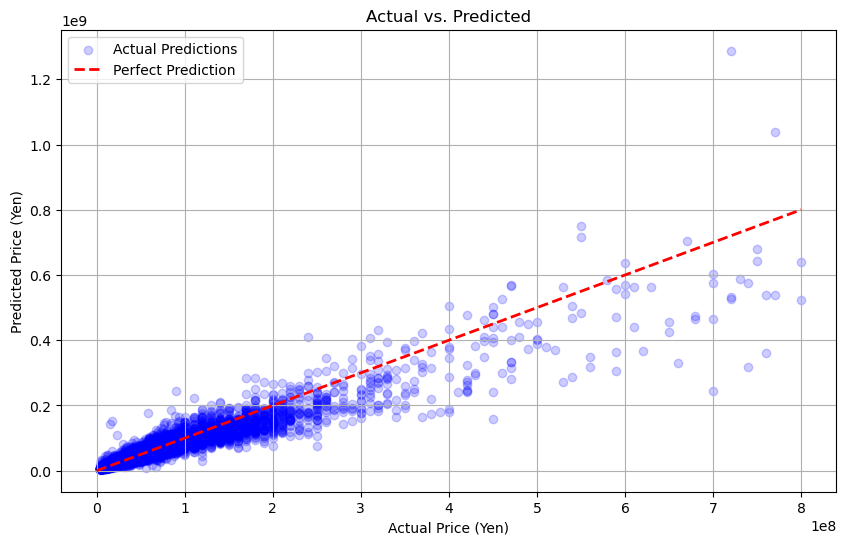

Average Bias: ¥3,986,235


In [8]:
# 1. Calculate Residuals (Actual - Predicted)
residuals = actual_yen - preds_yen

# 2. Plot Actual vs. Predicted
plt.figure(figsize=(10, 6))

# Scatter plot of the data
plt.scatter(actual_yen, preds_yen, alpha=0.2, color='blue', label='Actual Predictions')

# The "Perfect Prediction" Line
# Added label='Perfect Prediction' here so it shows up in the legend
plt.plot([0, 800000000], [0, 800000000], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual Price (Yen)')
plt.ylabel('Predicted Price (Yen)')
plt.title('Actual vs. Predicted')
plt.grid(True)

# This command actually draws the box with the labels
plt.legend()

plt.show()

# 3. Check the "Bias"
print(f"Average Bias: ¥{np.mean(residuals):,.0f}")

# Mass Market Model (Luxury Properties Excluded: 200M+ Yen)

In [9]:
# 1. Reload and Filter Data
df_standard = pd.read_parquet('../data/tokyo-preprocessed.parquet')

# --- FILTER ---
# Exclude luxury properties over 200 Million Yen
df_standard = df_standard[df_standard['TradePriceYen'] < 200000000].copy()

# Reset Index is MANDATORY for TimeSeriesSplit after filtering
df_standard = df_standard.sort_values(['TransactionYear', 'TransactionQuarter']).reset_index(drop=True)

In [10]:
print("\n=======================================================")
print("  STARTING EXPERIMENT: STANDARD RESIDENTIAL (< ¥200M)  ")
print("=======================================================")

print(f"Filtered Dataset Shape: {df_standard.shape}")

# 2. Setup Features (X) and Target (y)
target_col = 'LogTradePriceYen'
drop_cols = ['TradePriceYen', 'LogTradePriceYen', 'TransactionQuarterEndDate']

X_std = df_standard.drop(columns=drop_cols)
y_std = df_standard[target_col]

# 3. Categorical Columns (Same as before)
cat_cols = [
    'Municipality', 'DistrictName', 'Use', 'Structure', 'LandShape',
    'Renovation', 'Purpose', 'Type', 'Region', 'CityPlanning',
    'Classification', 'RoadDirection', 'Remarks'
]

# 4. Run Time Series Validation (Same parameters)
tscv = TimeSeriesSplit(n_splits=5)
results_std = []
fold = 0

for train_index, test_index in tscv.split(X_std):
    fold += 1
    X_train, X_test = X_std.iloc[train_index], X_std.iloc[test_index]
    y_train, y_test = y_std.iloc[train_index], y_std.iloc[test_index]
    
    # Target Encode
    encoder = ce.TargetEncoder(cols=cat_cols, smoothing=10)
    X_train_enc = encoder.fit_transform(X_train, y_train)
    X_test_enc = encoder.transform(X_test)
    
    # Train XGBoost
    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42,
        early_stopping_rounds=50
    )
    
    model.fit(
        X_train_enc, y_train,
        eval_set=[(X_test_enc, y_test)],
        verbose=False
    )
    
    # Eval
    preds_yen = np.exp(model.predict(X_test_enc))
    actual_yen = np.exp(y_test)
    mae = mean_absolute_error(actual_yen, preds_yen)
    print(f"Standard Fold {fold}: MAE: ¥{mae:,.0f}")
    results_std.append(mae)

print(f"Average MAE (Standard Model): ¥{np.mean(results_std):,.0f}")


  STARTING EXPERIMENT: STANDARD RESIDENTIAL (< ¥200M)  
Filtered Dataset Shape: (503004, 35)
Standard Fold 1: MAE: ¥7,129,877
Standard Fold 2: MAE: ¥7,347,339
Standard Fold 3: MAE: ¥7,481,872
Standard Fold 4: MAE: ¥7,635,552
Standard Fold 5: MAE: ¥9,377,433
Average MAE (Standard Model): ¥7,794,415


In [11]:
# 5. Final Check: 2025 Validation & Plots
print("\n--- 2025 Standard Validation ---")

# Manual Split
split_date = '2025-04-01'
mask_train = df_standard['TransactionQuarterEndDate'] < split_date
mask_test  = df_standard['TransactionQuarterEndDate'] >= split_date

X_train_25 = X_std[mask_train]
y_train_25 = y_std[mask_train]
X_test_25  = X_std[mask_test]
y_test_25  = y_std[mask_test]

# Fit Final Encoder/Model
std_encoder = ce.TargetEncoder(cols=cat_cols, smoothing=10)
std_model = xgb.XGBRegressor(
    n_estimators=1000, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, n_jobs=-1,
    random_state=42, early_stopping_rounds=50
)

X_train_enc = std_encoder.fit_transform(X_train_25, y_train_25)
X_test_enc = std_encoder.transform(X_test_25)

std_model.fit(
    X_train_enc, y_train_25, 
    eval_set=[(X_test_enc, y_test_25)], 
    verbose=False
)

# Predict
preds_yen = np.exp(std_model.predict(X_test_enc))
actual_yen = np.exp(y_test_25)

# Calculate Metrics
mae_25 = mean_absolute_error(actual_yen, preds_yen)
mape_25 = np.mean(np.abs((actual_yen - preds_yen) / actual_yen)) * 100
residuals = actual_yen - preds_yen

print(f"Standard MAE (2025): ¥{mae_25:,.0f}")
print(f"Standard MAPE (2025): {mape_25:.2f}%")


--- 2025 Standard Validation ---
Standard MAE (2025): ¥8,842,887
Standard MAPE (2025): 17.23%


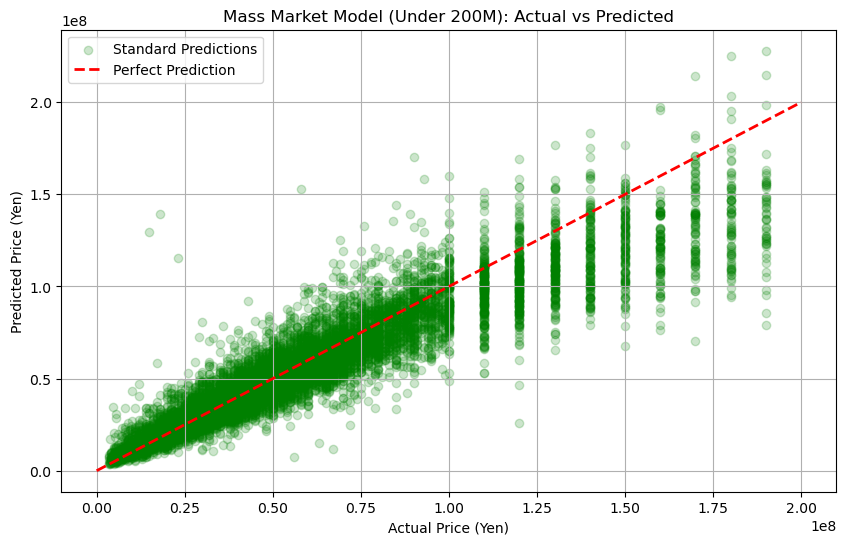

Average Bias: ¥2,723,653


In [12]:
# note that MLIT starts rounding prices into buckets when the traction price is > 100M yen

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_yen, preds_yen, alpha=0.2, color='green', label='Standard Predictions')
plt.plot([0, 200000000], [0, 200000000], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price (Yen)')
plt.ylabel('Predicted Price (Yen)')
plt.title('Mass Market Model (Under 200M): Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

print(f"Average Bias: ¥{np.mean(residuals):,.0f}")

In [13]:
# Check the percentage of data lost if we cut the luxury properties at 200M
total_rows = len(df)
over_200m = len(df[df['TradePriceYen'] >= 200000000])

print(f"Total Rows: {total_rows}")
print(f"Over ¥200M: {over_200m} rows ({over_200m/total_rows:.1%})")

Total Rows: 517025
Over ¥200M: 14021 rows (2.7%)


In [16]:
from sklearn.model_selection import RandomizedSearchCV

print("\n=======================================================")
print("  STARTING DISCOVERY: WIDE RANDOM SEARCH    ")
print("=======================================================")

# 1. Prepare Data
# Target Encode first to speed up the search loop
search_encoder = ce.TargetEncoder(cols=cat_cols, smoothing=10)
X_std_encoded = search_encoder.fit_transform(X_std, y_std)

# 2. Define a "Wide" Discovery Grid
param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],    
    'max_depth': [4, 6, 8, 10, 12],             
    'min_child_weight': [1, 3, 5, 7],           
    'subsample': [0.6, 0.8, 1.0],               
    'colsample_bytree': [0.6, 0.8, 1.0],        
    'n_estimators': [1000, 1500]                
}

# 3. Setup Base Model
# FIX: Removed 'early_stopping_rounds' so it works with RandomizedSearchCV
xgb_base = xgb.XGBRegressor(
    n_jobs=-1,
    random_state=42,
    tree_method='hist' 
)

# 4. Run Randomized Search
search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=20,                         
    scoring='neg_mean_absolute_error',
    cv=tscv,                           
    verbose=3,
    random_state=42,
    n_jobs=-1
)

print(f"Prospecting 20 random models across {tscv.n_splits} time periods...")
search.fit(X_std_encoded, y_std)


  STARTING DISCOVERY: WIDE RANDOM SEARCH    
Prospecting 20 random models across 5 time periods...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=1500, subsample=1.0;, score=-0.202 total time=  11.4s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=1500, subsample=1.0;, score=-0.188 total time=  20.5s
[CV 1/5] END colsample_bytree=0.6, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=1000, subsample=0.6;, score=-0.193 total time=  21.9s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=1500, subsample=1.0;, score=-0.172 total time=  28.8s
[CV 2/5] END colsample_bytree=0.6, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=1000, subsample=0.6;, score=-0.177 total time=  32.7s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_dept

/Users/pabloguevara/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1500, subsample=0.6;, score=-0.173 total time=  35.4s
[CV 4/5] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1500, subsample=0.6;, score=-0.167 total time=  44.3s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=12, min_child_weight=1, n_estimators=1500, subsample=0.8;, score=-0.193 total time= 2.2min
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1500, subsample=0.6;, score=-0.188 total time=  57.3s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=12, min_child_weight=1, n_estimators=1500, subsample=0.8;, score=-0.186 total time= 2.8min
[CV 1/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, min_child_weight=3, n_estimators=1500, subsample=0.6;, score=-0.205 total time= 1.5min
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=10, m

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBRegressor(...state=42, ...)"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bytree': [0.6, 0.8, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [4, 6, ...], 'min_child_weight': [1, 3, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",20
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'neg_mean_absolute_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategie

In [17]:
# 5. Report Results
print("\n--- Discovery Results ---")
print(f"Best Parameters Found: {search.best_params_}")
print(f"Best Log-Scale MAE: {abs(search.best_score_):.4f}")

# Translation to Yen
sample_price = 50000000
log_error = abs(search.best_score_)
approx_yen_error = sample_price * (np.expm1(log_error))
print(f"Approximate error on a ¥50M home: ±¥{approx_yen_error:,.0f}")


--- Discovery Results ---
Best Parameters Found: {'subsample': 1.0, 'n_estimators': 1500, 'min_child_weight': 7, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best Log-Scale MAE: 0.1698
Approximate error on a ¥50M home: ±¥9,253,095


In [ ]:
from sklearn.base import clone

print("\n=======================================================")
print("  VALIDATING BEST PARAMS ON 2025 FUTURE DATA           ")
print("=======================================================")

# 1. Retrieve the Best Parameters
print(f"Winner Params: {search.best_params_}")

# 2. Create a Fresh Model with these exact parameters
# We use clone() to copy the configuration without copying the trained weights
best_model = clone(search.best_estimator_)

# Ensure specific fixed params are set (just in case)
best_model.set_params(n_jobs=-1, random_state=42, early_stopping_rounds=50)

# 3. Setup the 2025 Split (Strict Past vs Future)
split_date = '2025-04-01'
mask_train = df_standard['TransactionQuarterEndDate'] < split_date
mask_test  = df_standard['TransactionQuarterEndDate'] >= split_date

X_train_25 = X_std[mask_train]
y_train_25 = y_std[mask_train]
X_test_25  = X_std[mask_test]
y_test_25  = y_std[mask_test]

print(f"Training on {len(X_train_25)} rows (Pre-April 2025)...")

# 4. Strict Target Encoding (Fit on Train ONLY)
# We do not use X_std_encoded here because that would be data leakage
final_encoder = ce.TargetEncoder(cols=cat_cols, smoothing=10)
X_train_enc = final_encoder.fit_transform(X_train_25, y_train_25)
X_test_enc = final_encoder.transform(X_test_25)

# 5. Train the Winner
best_model.fit(
    X_train_enc, y_train_25,
    eval_set=[(X_test_enc, y_test_25)],
    verbose=False
)

# 6. Predict & Evaluate
preds_log = best_model.predict(X_test_enc)
preds_yen = np.exp(preds_log)
actual_yen = np.exp(y_test_25)

# Metrics
mae_25 = mean_absolute_error(actual_yen, preds_yen)
mape_25 = np.mean(np.abs((actual_yen - preds_yen) / actual_yen)) * 100
residuals = actual_yen - preds_yen

print("\n--- Final 2025 Performance ---")
print(f"MAE:  ¥{mae_25:,.0f}")
print(f"MAPE: {mape_25:.2f}%")
print(f"Bias: ¥{np.mean(residuals):,.0f}")


  VALIDATING BEST PARAMS ON 2025 FUTURE DATA           
Winner Params: {'subsample': 1.0, 'n_estimators': 1500, 'min_child_weight': 7, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Training on 491875 rows (Pre-April 2025)...

--- Final 2025 Performance ---
MAE:  ¥7,538,968
MAPE: 15.20%
Bias: ¥2,198,154


In [24]:
# --- Optimized model (Found via RandomizedSearchCV on Dec 16, 2025) ---
# Previous Baseline MAE: ¥8,842,887 (MAPE 17.2%)
# Optimized MAE:         ¥7,538,968 (MAPE 15.2%)

best_params = {
    'subsample': 1.0, 
    'n_estimators': 1500, 
    'min_child_weight': 7, 
    'max_depth': 10, 
    'learning_rate': 0.05, 
    'colsample_bytree': 0.8,
    'n_jobs': -1,
    'random_state': 42,
    'tree_method': 'hist'
}

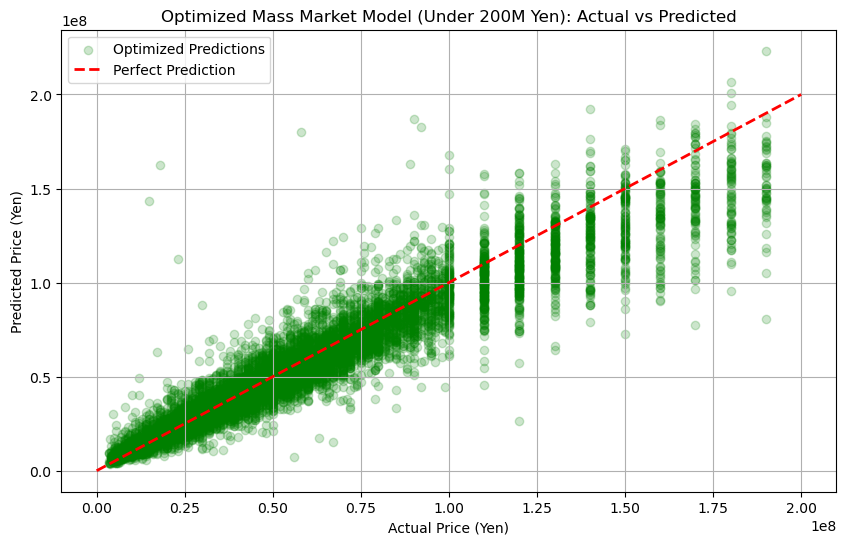

Average Bias: ¥2,198,154


In [25]:
# 1. Setup the Plot
plt.figure(figsize=(10, 6))

# 2. Scatter Plot (Green for "Go/Good")
plt.scatter(actual_yen, preds_yen, alpha=0.2, color='green', label='Optimized Predictions')

# 3. The "Perfect" Line (Red Dashed)
# We plot from 0 to 200M since that's our cutoff
plt.plot([0, 200000000], [0, 200000000], 'r--', lw=2, label='Perfect Prediction')

# 4. Labels and Title with dynamic metrics
plt.xlabel('Actual Price (Yen)')
plt.ylabel('Predicted Price (Yen)')
plt.title(f'Optimized Mass Market Model (Under 200M Yen): Actual vs Predicted')

plt.legend()
plt.grid(True)
plt.show()

# 5. Print the Bias (The "Katayori" / 偏り)
print(f"Average Bias: ¥{np.mean(residuals):,.0f}")